In [64]:
%matplotlib inline

In [65]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Read dataset GNI_Surface

### Import dataset

In [66]:
dfgni = pd.read_csv("GNI_Surface_Data.txt",sep="\t",header=0)
dfgni.head()

,Time,Time Code,Country Name,Country Code,Surface,Population,GNI
0,2010,YR2010,Afghanistan,AFG,652860,2.880317e+07,15998801042.3649
1,2010,YR2010,Bangladesh,BGD,148460,1.521491e+08,124617096900.553
2,2010,YR2010,Bhutan,BTN,38394,7.276410e+05,1497491569.31098
3,2010,YR2010,India,IND,3287260,1.230981e+09,1638663459970.89
4,2010,YR2010,Maldives,MDV,300,3.645110e+05,2276923140.625


### Drop rows with missing values

In [67]:
dfgni = dfgni.dropna()
dfgni

,Time,Time Code,Country Name,Country Code,Surface,Population,GNI
0,2010,YR2010,Afghanistan,AFG,652860,2.880317e+07,15998801042.3649
1,2010,YR2010,Bangladesh,BGD,148460,1.521491e+08,124617096900.553
2,2010,YR2010,Bhutan,BTN,38394,7.276410e+05,1497491569.31098
3,2010,YR2010,India,IND,3287260,1.230981e+09,1638663459970.89
4,2010,YR2010,Maldives,MDV,300,3.645110e+05,2276923140.625
5,2010,YR2010,Nepal,NPL,147180,2.702314e+07,16124973167.3285
6,2010,YR2010,Pakistan,PAK,796100,1.705602e+08,184163841544.981
7,2010,YR2010,Sri Lanka,LKA,65610,2.019835e+07,56110843799.7523
8,2010,YR2010,Albania,ALB,28750,2.913021e+06,11807797845.6056
9,2010,YR2010,Andorra,AND,470,8.444900e+04,..


# Read dataset 

### Import dataset

In [76]:
dfautres = pd.read_csv("autres_Data.txt",sep="\t",header=0)
dfautres.tail()

,Time,Time Code,Country Name,Country Code,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents
217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,Last Updated: 11/14/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Drop rows with missing values

In [69]:
dfautres = dfautres.dropna()
dfautres.head()

,Time,Time Code,Country Name,Country Code,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents
0,2010,YR2010,Afghanistan,AFG,2.25547064,158,61.226,0.732845131003678
1,2010,YR2010,Bangladesh,BGD,4.07121264,119,70.198,1.30914401250957
2,2010,YR2010,Bhutan,BTN,6.47776914,..,67.79,5.15527031787468
3,2010,YR2010,India,IND,3.16940536,115,66.625,4.67104198378064
4,2010,YR2010,Maldives,MDV,13.60358367,79,76.112,0.00896594438201804


In [ ]:
len(dfautres)

# Merge datasets

In [70]:
data = pd.merge(dfgni, dfautres, how='inner', on=['Country Name', 'Country Code'])

In [71]:
data=data.drop(columns=['Time_x', 'Time Code_x', 'Time_y', 'Time Code_y' ])

In [72]:
# set index with country code
data = data.set_index('Country Code')

In [73]:
data.head()

,Country Name,Surface,Population,GNI,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents
Country Code,,,,,,,,
AFG,Afghanistan,652860,2.880317e+07,15998801042.3649,2.25547064,158,61.226,0.732845131003678
BGD,Bangladesh,148460,1.521491e+08,124617096900.553,4.07121264,119,70.198,1.30914401250957
BTN,Bhutan,38394,7.276410e+05,1497491569.31098,6.47776914,..,67.79,5.15527031787468
IND,India,3287260,1.230981e+09,1638663459970.89,3.16940536,115,66.625,4.67104198378064
MDV,Maldives,300,3.645110e+05,2276923140.625,13.60358367,79,76.112,0.00896594438201804


In [74]:
len(data)

217

# Boxplots

In [75]:
# set index with country code
dfautresn = dfautres
dfautresn = dfautresn.set_index('Country Code')
# boxplot with the dfautre dataset
dfautresn = dfautresn.iloc[:,3:]
Z_scored_dfautres = (dfautresn-dfautresn.mean())/dfautresn.std()
sns.boxplot(Z_scored_dfautres)

TypeError: Could not operate nan with block values can't multiply sequence by non-int of type 'float'

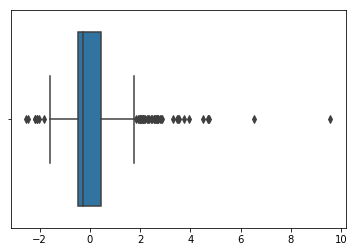

In [14]:
# boxplot with the whole dataset
datan = data.iloc[:,1:]
Z_scored_df = (datan-datan.mean())/datan.std()
sns.boxplot(Z_scored_df)

# Outliers detection

## dfautres

In [15]:
dfautresn.mean(axis=0) # moyenne des lignes pour chaque colonne

Gvnt_health_exp          2.306185
Food Deficit           112.448938
Life Expectancy         66.888517
Nat_resources_rents     10.876976
dtype: float64

In [16]:
threshold = 2.5
mask = np.abs(dfautresn) > dfautresn.mean()+threshold*dfautresn.std()
outliers = dfautresn[mask.any(axis=1)]

In [17]:
mask.head()

,Gvnt_health_exp,Food Deficit,Life Expectancy,Nat_resources_rents
Country Code,,,,
AFG,False,False,False,False
DZA,False,False,False,False
AGO,False,False,False,True
ARB,False,False,False,False
ARG,False,False,False,False


In [18]:
mask.any()

Gvnt_health_exp         True
Food Deficit            True
Life Expectancy        False
Nat_resources_rents     True
dtype: bool

In [19]:
data.loc[sorted(list(set(outliers.index)))]

,Country Name,GNI,Surface,Gvnt_health_exp,Food Deficit,Life Expectancy,Nat_resources_rents
Country Code,,,,,,,
AGO,Angola,7.443928e+10,1246700.0,1.704052,149.00000,58.192000,39.037754
COG,"Congo, Rep.",9.024207e+09,342000.0,0.906184,226.00000,60.473000,49.144419
CRI,Costa Rica,3.606001e+10,51100.0,5.931988,36.00000,78.756000,1.646853
HTI,Haiti,6.644822e+09,27750.0,0.577397,524.00000,61.296000,1.192176
IRQ,Iraq,1.401081e+11,435240.0,2.439981,209.00000,68.465000,41.477584
KIR,Kiribati,2.227444e+08,810.0,8.568862,30.00000,65.354000,0.063495
KWT,Kuwait,1.238811e+11,17820.0,2.333800,11.00000,73.979000,48.295617
MNG,Mongolia,6.609617e+09,1564120.0,2.376254,223.00000,67.383000,38.659926
MRT,Mauritania,4.274665e+09,1030700.0,0.949203,54.00000,61.997000,48.699262


In [20]:
mask.loc[sorted(list(set(outliers.index)))]

,Gvnt_health_exp,Food Deficit,Life Expectancy,Nat_resources_rents
Country Code,,,,
AGO,False,False,False,True
COG,False,False,False,True
CRI,True,False,False,False
HTI,False,True,False,False
IRQ,False,False,False,True
KIR,True,False,False,False
KWT,False,False,False,True
MNG,False,False,False,True
MRT,False,False,False,True


In [21]:
# we keep outliers not related to nat. ressources
maskbis=mask.iloc[:,:3]
outliersbis = dfautresn[maskbis.any(axis=1)]
outliersbis

,Gvnt_health_exp,Food Deficit,Life Expectancy,Nat_resources_rents
Country Code,,,,
CRI,5.931988,36.00000,78.756000,1.646853
HTI,0.577397,524.00000,61.296000,1.192176
KIR,8.568862,30.00000,65.354000,0.063495
WLD,5.881214,106.70026,70.682926,3.669809
ZMB,0.598581,455.00000,56.588000,21.387444


In [22]:
dfautrestri = dfautresn.loc[sorted(list(set(dfautresn.index).difference(set(outliersbis.index))))]
dfautrestri=dfautrestri.drop(["LMY","IBT","IBD","MIC","UMC"])
dfautrestri.head()

,Gvnt_health_exp,Food Deficit,Life Expectancy,Nat_resources_rents
Country Code,,,,
AFG,0.469157,158.000000,61.226000,0.732845
AGO,1.704052,149.000000,58.192000,39.037754
ARB,2.355628,73.402535,70.041054,27.643199
ARE,2.784156,35.000000,76.344000,20.580810
ARG,3.710831,10.000000,75.595000,3.137998


## data

In [23]:
datan.mean(axis=0) # moyenne des lignes pour chaque colonne

GNI                    1.892611e+12
Surface                7.561404e+06
Gvnt_health_exp        2.304122e+00
Food Deficit           1.119315e+02
Life Expectancy        6.693308e+01
Nat_resources_rents    1.094573e+01
dtype: float64

In [24]:
threshold = 2.5
mask2 = np.abs(datan) > datan.mean()+threshold*datan.std()
outliers2 = datan[mask2.any(axis=1)]

In [25]:
mask2.head()

,GNI,Surface,Gvnt_health_exp,Food Deficit,Life Expectancy,Nat_resources_rents
Country Code,,,,,,
AFG,False,False,False,False,False,False
DZA,False,False,False,False,False,False
AGO,False,False,False,False,False,True
ARB,False,False,False,False,False,False
ARG,False,False,False,False,False,False


In [26]:
mask2.any()

GNI                     True
Surface                 True
Gvnt_health_exp         True
Food Deficit            True
Life Expectancy        False
Nat_resources_rents     True
dtype: bool

In [27]:
mask2.loc[sorted(list(set(outliers2.index)))]

,GNI,Surface,Gvnt_health_exp,Food Deficit,Life Expectancy,Nat_resources_rents
Country Code,,,,,,
AGO,False,False,False,False,False,True
COG,False,False,False,False,False,True
CRI,False,False,True,False,False,False
HTI,False,False,False,True,False,False
IBD,True,True,False,False,False,False
IBT,True,True,False,False,False,False
IRQ,False,False,False,False,False,True
KIR,False,False,True,False,False,False
KWT,False,False,False,False,False,True


In [28]:
data.loc[sorted(list(set(outliers2.index)))]

,Country Name,GNI,Surface,Gvnt_health_exp,Food Deficit,Life Expectancy,Nat_resources_rents
Country Code,,,,,,,
AGO,Angola,7.443928e+10,1246700.0,1.704052,149.000000,58.192000,39.037754
COG,"Congo, Rep.",9.024207e+09,342000.0,0.906184,226.000000,60.473000,49.144419
CRI,Costa Rica,3.606001e+10,51100.0,5.931988,36.000000,78.756000,1.646853
HTI,Haiti,6.644822e+09,27750.0,0.577397,524.000000,61.296000,1.192176
IBD,IBRD only,1.966090e+13,71363385.0,2.605638,93.456233,71.304336,7.408159
IBT,IDA & IBRD total,2.108760e+13,98473626.0,2.497163,107.657787,68.924267,7.598569
IRQ,Iraq,1.401081e+11,435240.0,2.439981,209.000000,68.465000,41.477584
KIR,Kiribati,2.227444e+08,810.0,8.568862,30.000000,65.354000,0.063495
KWT,Kuwait,1.238811e+11,17820.0,2.333800,11.000000,73.979000,48.295617


In [29]:
# we keep outliers not related to nat. ressources
mask2bis=mask2.iloc[:,:4]
outliers2bis = datan[mask2bis.any(axis=1)]
outliers2bis

,GNI,Surface,Gvnt_health_exp,Food Deficit,Life Expectancy,Nat_resources_rents
Country Code,,,,,,
CRI,3.606001e+10,51100.0,5.931988,36.000000,78.756000,1.646853
HTI,6.644822e+09,27750.0,0.577397,524.000000,61.296000,1.192176
IBD,1.966090e+13,71363385.0,2.605638,93.456233,71.304336,7.408159
IBT,2.108760e+13,98473626.0,2.497163,107.657787,68.924267,7.598569
KIR,2.227444e+08,810.0,8.568862,30.000000,65.354000,0.063495
LMY,1.995197e+13,94546110.0,2.430999,109.561862,68.808719,7.741350
MIC,1.957162e+13,79863509.0,2.450285,98.764050,69.855798,7.671578
UMC,1.511562e+13,56967185.0,2.834836,82.096287,73.893614,7.835881
WLD,6.591609e+13,134311372.1,5.881214,106.700260,70.682926,3.669809


In [30]:
# remove outliers
datatri = datan.loc[sorted(list(set(datan.index).difference(set(outliers2bis.index))))]
datatri.head()

,GNI,Surface,Gvnt_health_exp,Food Deficit,Life Expectancy,Nat_resources_rents
Country Code,,,,,,
AFG,1.599880e+10,652860.0,0.469157,158.000000,61.226000,0.732845
AGO,7.443928e+10,1246700.0,1.704052,149.000000,58.192000,39.037754
ARB,2.091921e+12,13779283.0,2.355628,73.402535,70.041054,27.643199
ARE,2.897808e+11,83600.0,2.784156,35.000000,76.344000,20.580810
ARG,4.091479e+11,2780400.0,3.710831,10.000000,75.595000,3.137998


# Correlation

## dfautrestri

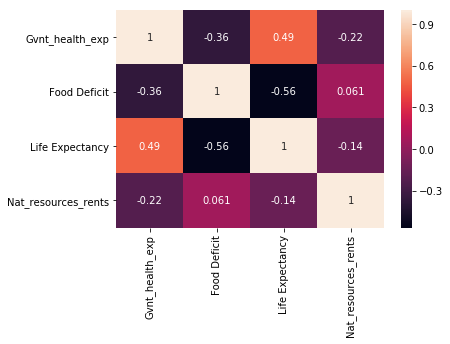

In [31]:
sns.heatmap(dfautrestri.corr(),annot=True)

## datatri

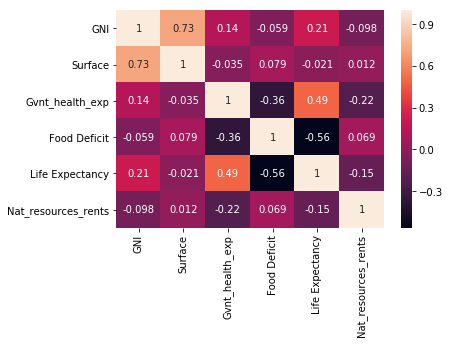

In [32]:
sns.heatmap(datatri.corr(),annot=True)

# Normalize data 

## dfautrestri

In [33]:
Z_dfautrestri = (dfautrestri - dfautrestri.mean())/dfautrestri.std()

In [34]:
# Represent the data using the parallel coordinates method
from pandas.plotting import parallel_coordinates
parallel_coordinates(dfautresn,'Country Code', alpha=0.2)
plt.show()

KeyError: 'Country Code'

## datatri

In [36]:
Z_datatri = (datatri - datatri.mean())/datatri.std()

# Clustering (dfautrestri)

## Hierarchical clustering

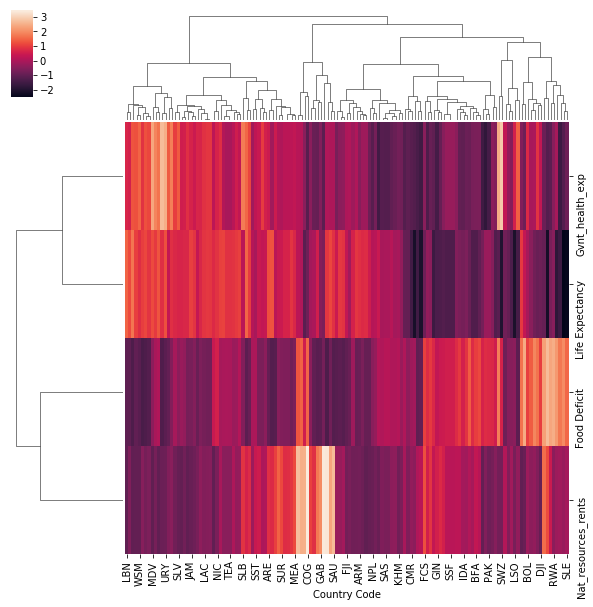

In [35]:
sns.clustermap(Z_dfautrestri.T,method='complete')

## Kmeans

In [38]:
## test du nombre de cluster:
SSE = [] #stockage des SSE pour chaque nombre de cluster
silh = [] #stockage des coeff silhouettes pour chaque nombre de cluster
for i in range(2,10):
    kmeans = KMeans(i)
    kmeans = kmeans.fit(Z_dfautrestri)
    Z_dfautrestri["cluster"] = kmeans.predict(Z_dfautrestri)
    SSE.append(kmeans.inertia_)
    silh.append(metrics.silhouette_score(Z_dfautrestri, Z_dfautrestri["cluster"], metric='euclidean', sample_size=None))

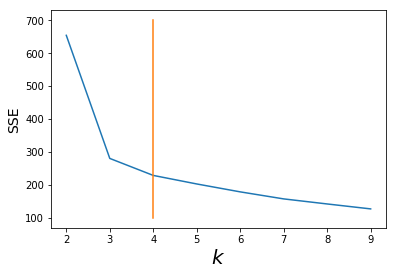

In [86]:
## graphe de la SSE:
plt.plot(range(2,10),SSE)
plt.plot([4,4],[100,700])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("SSE",fontsize=14)

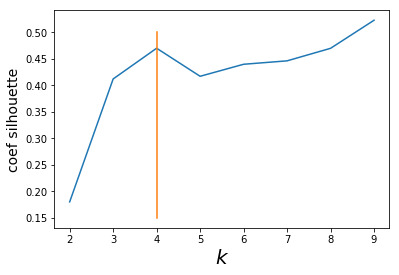

In [85]:
## coeff silhouette:
plt.plot(range(2,10),silh)
plt.plot([4,4],[0.15,0.5])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("coef silhouette",fontsize=14)

In [54]:
from sklearn.cluster import KMeans
kmeans = KMeans(4)
kmeans = kmeans.fit(Z_dfautrestri)
Z_dfautrestri["cluster"] = kmeans.predict(Z_dfautrestri)

In [55]:
metrics.silhouette_score(Z_dfautrestri, Z_dfautrestri["cluster"], metric='euclidean', sample_size=None)

0.3632687160936854

In [56]:
sse = kmeans.inertia_
print "sse =", sse

sse = 255.77693423181725


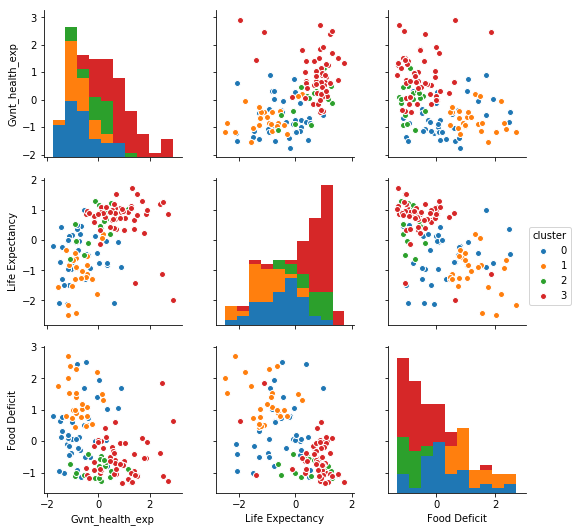

In [57]:
sns.pairplot(Z_dfautrestri,vars=["Gvnt_health_exp","Life Expectancy","Food Deficit"],hue="cluster")

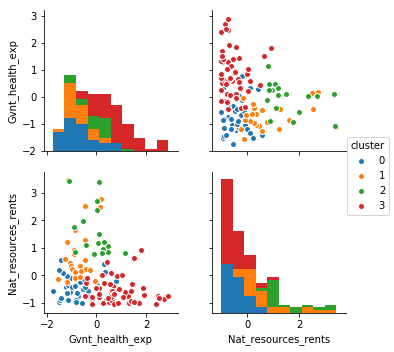

In [58]:
sns.pairplot(Z_dfautrestri,vars=["Gvnt_health_exp","Nat_resources_rents"],hue="cluster")

### Stability

In [69]:
silhouette_coef = []
sse = []
k = 4
n_init=1
for i in range(100):
    km = KMeans(n_clusters=k, n_init=n_init, random_state=i) # create a KMeans object
    km.fit(Z_dfautrestri)
    labels = km.predict(Z_dfautrestri)
    sse.append(km.inertia_)
    silhouette_coef.append(silhouette_score(Z_dfautrestri, labels, metric='euclidean', sample_size=None))

(array([67.,  0., 10.,  1., 12.,  3.,  1.,  0.,  3.,  3.]),
 array([239.39160583, 245.47072402, 251.54984221, 257.6289604 ,
        263.70807859, 269.78719678, 275.86631496, 281.94543315,
        288.02455134, 294.10366953, 300.18278772]),
 <a list of 10 Patch objects>)

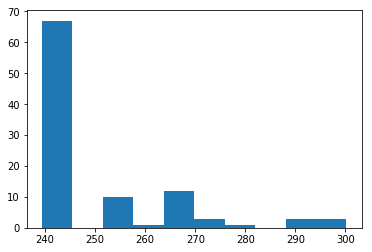

In [70]:
plt.hist(sse)

(array([ 3.,  1.,  3.,  5., 47., 29.,  6.,  0.,  0.,  6.]),
 array([0.3035186 , 0.31739732, 0.33127604, 0.34515477, 0.35903349,
        0.37291221, 0.38679093, 0.40066965, 0.41454838, 0.4284271 ,
        0.44230582]),
 <a list of 10 Patch objects>)

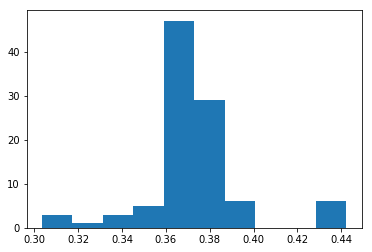

In [71]:
plt.hist(silhouette_coef)

In [72]:
def compute_stability(k,df,iterations=100):
    silhouette_coef = []
    for i in range(iterations):
        km = KMeans(n_clusters=k, n_init=1, random_state=i) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
    silhouette_coef = np.asarray(silhouette_coef)
    return(silhouette_coef.std())

In [73]:
stability = []
Ks = range(2,30)
for k in Ks:
    stability.append(compute_stability(k,Z_dfautrestri))

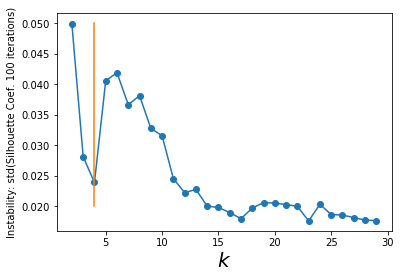

In [84]:
plt.plot(Ks,stability,"o-")
plt.plot([4,4],[0.02,0.050])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("Instability: std(Silhouette Coef. 100 iterations)")

###### ==> we'll keep 4 clusters

## DBSCAN